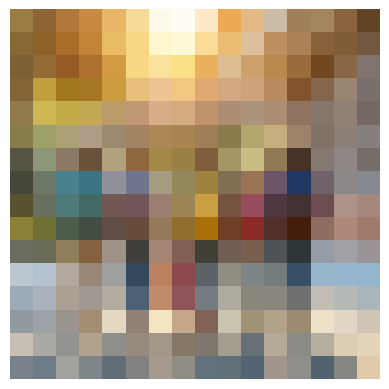

In [1]:
#1. Lets load the image as array
from PIL import Image
import requests
from io import BytesIO
from matplotlib import pyplot as plt
import math

#url = "https://cdn.pixabay.com/photo/2024/05/20/08/16/ai-generated-8774108_1280.jpg"
#url = "https://cdn.pixabay.com/photo/2024/01/03/17/53/sunset-8485916_1280.jpg"
#url = "https://cdn.pixabay.com/photo/2020/05/05/23/08/africa-5135407_1280.jpg"
#url = "https://cdn.pixabay.com/photo/2024/03/29/10/32/blue-macaw-8662605_1280.jpg"
url = "https://cdn.pixabay.com/photo/2024/09/08/18/19/ai-generated-9032884_1280.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
# Resize to something more viable for all algs. (max. around 48x48)
img = img.resize((16,16))

#We can use matplotlib to show the image.
plt.axis('off')
plt.imshow(img)

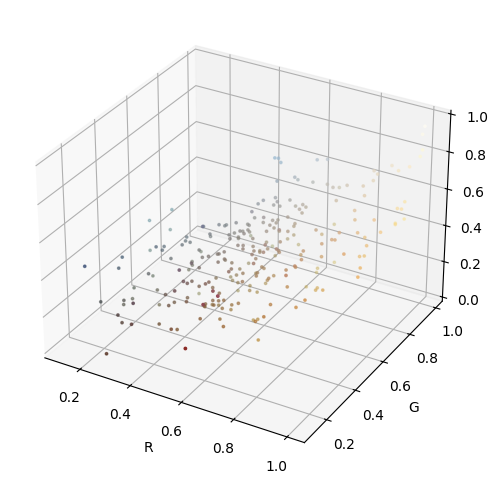

In [2]:
#2. Map the colors to [0; 1] and show the different colors in 3D space
import numpy as np

#Convert the image to a 3D Array
img = np.asarray(img)

#Reshapre the array to a 1D array and convert values to fit in range [0; 1].
img_flatt = img.reshape(img.shape[0] * img.shape[1], 3)
imgArr = np.copy(img_flatt /255)

#As we would like to only look at a part of the color samples, we shuffle the
#array to make shure the selected pixels are representive of the whole image.
np.random.shuffle(imgArr)

#Get the colors as array.
R = imgArr[:, 0]
G = imgArr[:, 1]
B = imgArr[:, 2]

#Show the colors using matplotlib. Select only a few pixels,
#else the graphic becomes to crowded
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(R[:10000], G[:10000], B[:10000], s=3, c = imgArr[:10000])
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.show()

In [3]:
#3. Implement hirachical clustering to reduce the colors in the image.
input_image = np.copy(img_flatt)
result_image = np.array(img_flatt)

# Define distance calculation functions
def CalcEuclide(pixel1, pixel2):
    return np.linalg.norm(pixel1 - pixel2)

def CalcManhatten(pixel1, pixel2):
    return np.sum(np.abs(pixel1 - pixel2))

# Find the colors with the smallest distance
def FindTheSmallestDistance(clusters):
    shortestDistance = float('inf')
    closestPair = (None, None)

    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            distance = CalcEuclide(clusters[i]['value'], clusters[j]['value'])
            if distance < shortestDistance:
                shortestDistance = distance
                closestPair = (i, j)
    return shortestDistance, closestPair

# Implement hierarchical clustering with a specified number of clusters
def FindRepresentivs(input_image, num_clusters):
    # Initialize clusters
    clusters = []
    for idx in range(len(input_image)):
        clusters.append({'pixels': [idx], 'value': input_image[idx]})

    # Repeat until the desired number of clusters is reached
    while len(clusters) > num_clusters:
        _, (i, j) = FindTheSmallestDistance(clusters)
        if i is None or j is None:
            break

        # Merge the two closest clusters
        merged_pixels = clusters[i]['pixels'] + clusters[j]['pixels']

        # Calculate the median color of the merged cluster
        pixel_values = input_image[merged_pixels]
        median_color = np.median(pixel_values, axis=0)

        # Create new cluster
        new_cluster = {'pixels': merged_pixels, 'value': median_color}

        # Remove old clusters and add new cluster
        clusters.pop(max(i, j))  # Remove the cluster with the higher index first
        clusters.pop(min(i, j))
        clusters.append(new_cluster)

    # Create a result image where each pixel is replaced by its cluster's median color
    result_image = np.zeros_like(input_image)
    for cluster in clusters:
        for idx in cluster['pixels']:
            result_image[idx] = cluster['value']
    return result_image

# Set the desired number of clusters
desired_num_clusters = 8

# Apply the hierarchical clustering
result_image = FindRepresentivs(input_image, desired_num_clusters)


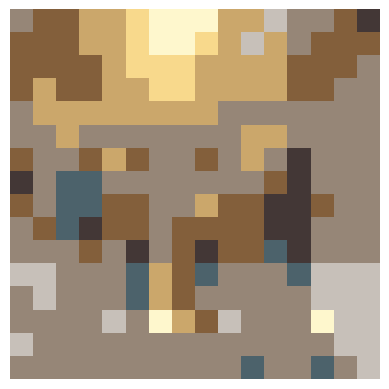

In [4]:
# 4. Let's unflatten the array to show it as an image.
# Ensure the result_image has the same number of elements as the original image
if result_image.size != img.size:
    raise ValueError("The size of result_image does not match the original image size.")

# Reshape and display the clustered image
reduced_image = result_image.reshape(img.shape[0], img.shape[1], 3)

plt.axis('off')
plt.imshow(reduced_image)
plt.show()
